In [1]:
pip install yfinance

In [4]:
import yfinance as yf
data = yf.download('^NSEI','2009-01-01','2023-12-19')

[*********************100%%**********************]  1 of 1 completed


In [5]:
print(data.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2009-01-02  3034.600098  3079.850098  3021.800049  3046.750000  3046.750000   
2009-01-05  3058.750000  3131.949951  3056.449951  3121.449951  3121.449951   
2009-01-06  3121.500000  3141.800049  3056.100098  3112.800049  3112.800049   
2009-01-07  3112.800049  3147.199951  2888.199951  2920.399902  2920.399902   
2009-01-09  2919.949951  2929.850098  2810.250000  2873.000000  2873.000000   

            Volume  
Date                
2009-01-02       0  
2009-01-05       0  
2009-01-06       0  
2009-01-07       0  
2009-01-09       0  


In [6]:
import pandas as pd
import keras as ks
import numpy as np
df = pd.DataFrame(data)

In [7]:
print(df.head())
print(df.tail())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2009-01-02  3034.600098  3079.850098  3021.800049  3046.750000  3046.750000   
2009-01-05  3058.750000  3131.949951  3056.449951  3121.449951  3121.449951   
2009-01-06  3121.500000  3141.800049  3056.100098  3112.800049  3112.800049   
2009-01-07  3112.800049  3147.199951  2888.199951  2920.399902  2920.399902   
2009-01-09  2919.949951  2929.850098  2810.250000  2873.000000  2873.000000   

            Volume  
Date                
2009-01-02       0  
2009-01-05       0  
2009-01-06       0  
2009-01-07       0  
2009-01-09       0  
                    Open          High           Low         Close  \
Date                                                                 
2023-12-12  21018.550781  21037.900391  20867.150391  20906.400391   
2023-12-13  20929.750000  20950.000000  20769.500000  20926.349609   
2023-12-14  21110.4

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
print(df)
print(scaled_df)

                    Open          High           Low         Close  \
Date                                                                 
2009-01-02   3034.600098   3079.850098   3021.800049   3046.750000   
2009-01-05   3058.750000   3131.949951   3056.449951   3121.449951   
2009-01-06   3121.500000   3141.800049   3056.100098   3112.800049   
2009-01-07   3112.800049   3147.199951   2888.199951   2920.399902   
2009-01-09   2919.949951   2929.850098   2810.250000   2873.000000   
...                  ...           ...           ...           ...   
2023-12-12  21018.550781  21037.900391  20867.150391  20906.400391   
2023-12-13  20929.750000  20950.000000  20769.500000  20926.349609   
2023-12-14  21110.400391  21210.900391  21074.449219  21182.699219   
2023-12-15  21287.449219  21492.300781  21235.300781  21456.650391   
2023-12-18  21434.800781  21482.800781  21365.349609  21418.650391   

               Adj Close  Volume  
Date                              
2009-01-02   3046.7

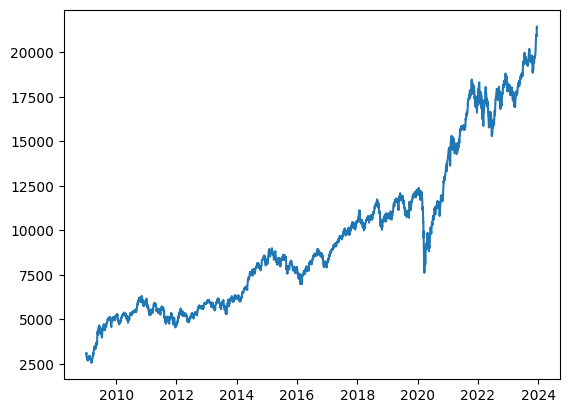

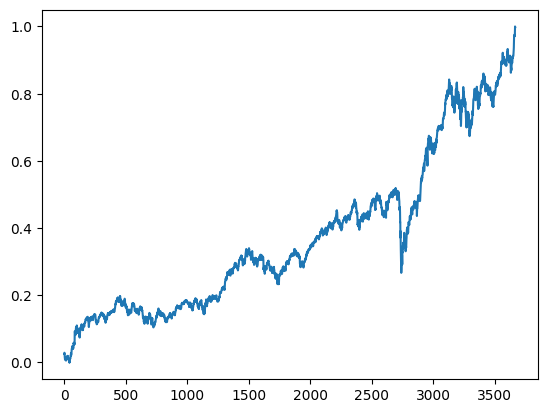

In [32]:
import matplotlib.pyplot as plt
plt.plot(df['Close'])
plt.show()
plt.plot(scaled_df['Close'])
plt.show()




The ACF and PACF plots show that there is some significant autocorrelation in the data, with the first few lags being the most significant. This suggests that the data may be non-stationary, and that a differencing transformation may be necessary to make it stationary.

The PACF plot shows that there is also some significant partial autocorrelation, with the first few lags being the most significant. This suggests that the data may have some serial correlation, and that an ARIMA model may be appropriate for forecasting.

In order to determine the best model for forecasting the data, it would be necessary to perform further analysis, such as fitting different ARIMA models and evaluating their performance on a holdout test set.

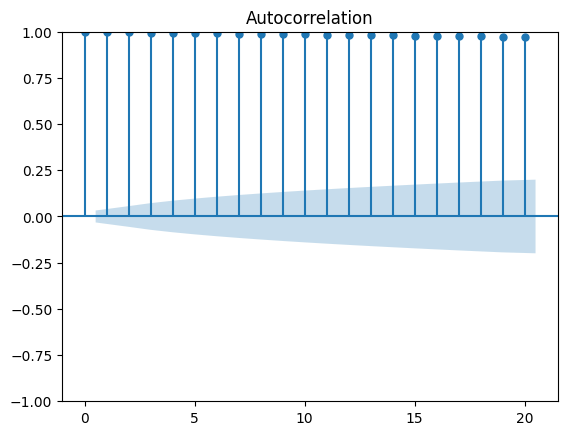

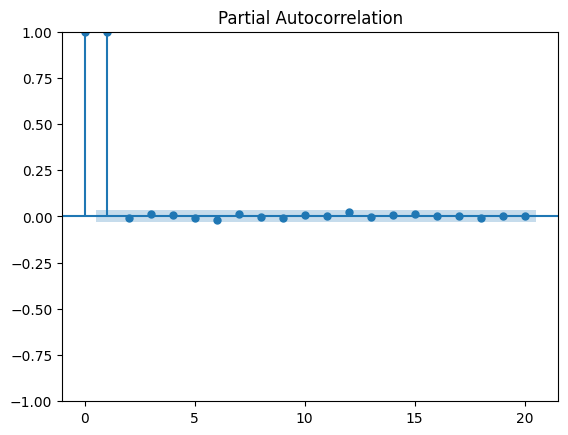

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(scaled_df['Close'], lags=20)
plt.show()
plot_pacf(scaled_df['Close'], lags=20)
plt.show()




Fixed size window

In [90]:


# Function to create sequences from the time series data
def create_sequences(data, window_size, stride):
    sequences = []
    targets = []
    for i in range(0, len(data) - window_size , stride):
        sequence = data.iloc[i:i+window_size]['Close'].values
        target = data.iloc[i+window_size]['Close']
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Set the window size and stride
window_size = 5
stride = 1

# Create sequences and targets
sequences, targets = create_sequences(scaled_df, window_size, stride)

# Reshape sequences for compatibility with train_test_split
sequences = sequences.reshape(-1, window_size)

# Split the data into training, validation, and test sets
# For simplicity, let's use an 80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2929, 5)
X_val shape: (366, 5)
X_test shape: (367, 5)
y_train shape: (2929,)
y_val shape: (366,)
y_test shape: (367,)


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(2929, 5, 1)
(366, 5, 1)
(367, 5, 1)


Building the LSTM model

In [17]:

model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Fifth LSTM layer
model.add(LSTM(units=32))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation="linear"))

model.summary()




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 50)             10400     
                                                                 
 dropout_10 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_15 (LSTM)              (None, 5, 32)             10624     
                                                                 
 dropout_11 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_16 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_12 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_17 (LSTM)              (None, 5, 32)            

In [58]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Print keys in history.history
keys = list(history.history.keys())
print("Available keys in history.history:", keys)

Epoch 1/100
92/92 [==============================] - 13s 48ms/step - loss: 7.1594e-04 - mae: 0.0193 - val_loss: 9.4463e-05 - val_mae: 0.0068
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 7.7473e-04 - mae: 0.0200 - val_loss: 3.6022e-04 - val_mae: 0.0160
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 7.5807e-04 - mae: 0.0201 - val_loss: 2.5720e-04 - val_mae: 0.0139
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 6.8006e-04 - mae: 0.0191 - val_loss: 1.0083e-04 - val_mae: 0.0074
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 7.6065e-04 - mae: 0.0204 - val_loss: 4.0251e-04 - val_mae: 0.0181
Epoch 6/100
92/92 [==============================] - 2s 17ms/step - loss: 7.9032e-04 - mae: 0.0205 - val_loss: 2.0664e-04 - val_mae: 0.0108
Epoch 7/100
92/92 [==============================] - 2s 21ms/step - loss: 7.4020e-04 - mae: 0.0194 - val_loss: 1.7862e-04 - val_mae: 0.0107
Epoch 8/100
92/92 [

12/12 [==============================] - 2s 6ms/step


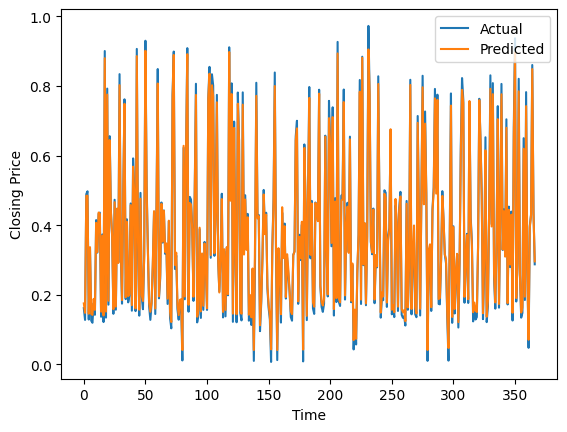

In [59]:

import matplotlib.pyplot as plt
predictions = model.predict(X_test)
plt.plot(y_test, label="Actual")
plt.plot(predictions, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


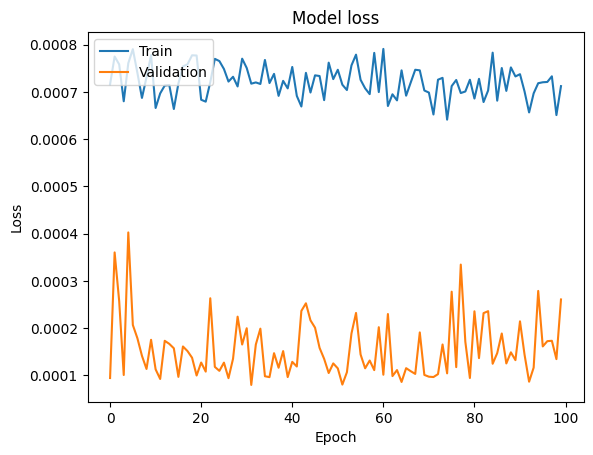

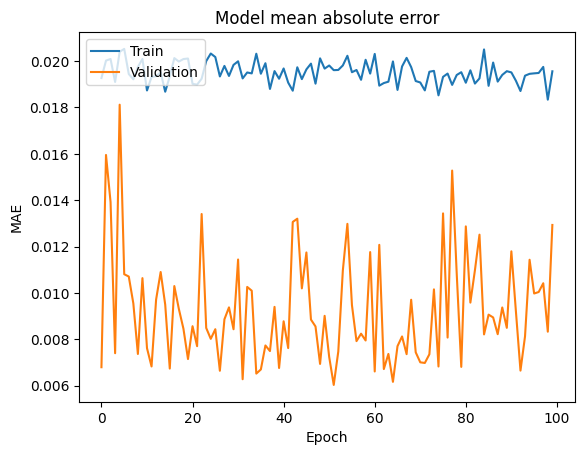

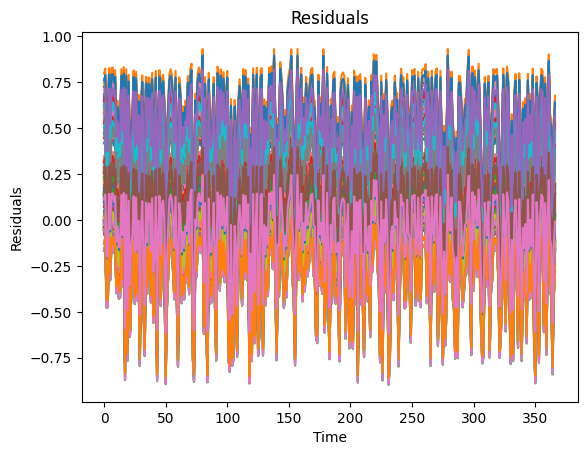

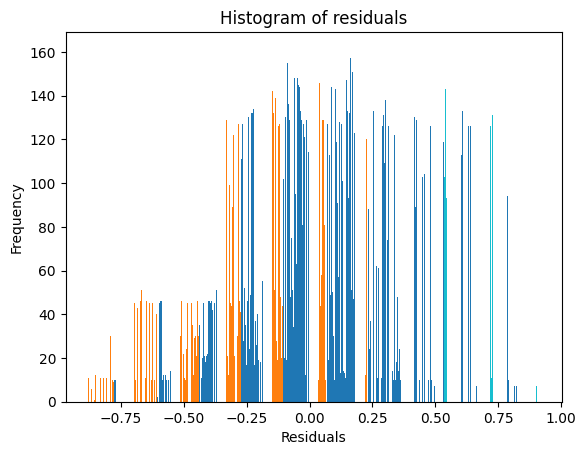

In [65]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mean absolute error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Residuals
residuals = y_test - predictions
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.hist(residuals)
plt.title('Histogram of residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



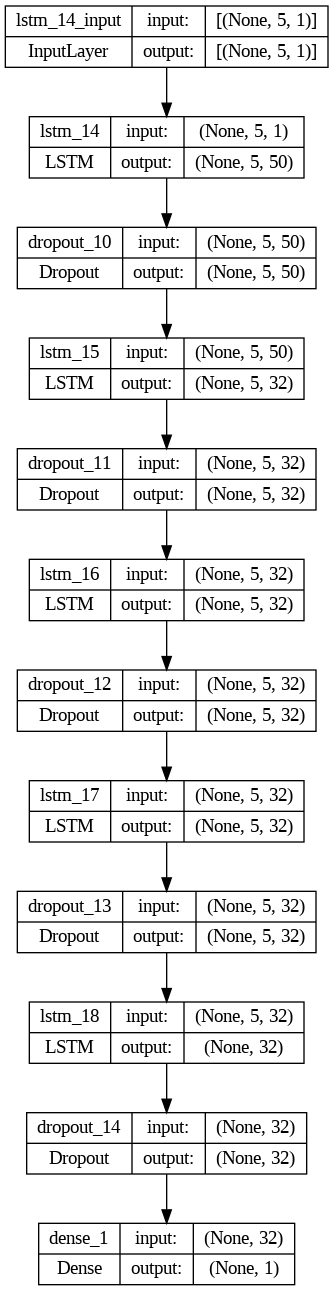

In [67]:

from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


In [21]:

# Replace X_new with your actual new dataset

X_new = yf.download('^NSEI','2023-01-01','2023-12-19')

scaler1 = MinMaxScaler()
scaled_data1 = scaler1.fit_transform(X_new)
scaled_df1 = pd.DataFrame(scaled_data1, columns=X_new.columns)

scaled_df1 = scaled_df1.to_numpy()

# Reshape X_new for LSTM input
scaled_df1 = scaled_df1.reshape((scaled_df1.shape[0], scaled_df1.shape[1], 1))

# Make predictions using the trained model
new_predictions = model.predict(scaled_df1)




print("Predictions:")
print(new_predictions)



[*********************100%%**********************]  1 of 1 completed
8/8 [==============================] - 2s 6ms/step
Predictions:
[[ 2.5964594e-01]
 [ 2.6661155e-01]
 [ 2.4920709e-01]
 [ 2.2080997e-01]
 [ 1.8554014e-01]
 [ 2.2190784e-01]
 [ 2.1462169e-01]
 [ 1.8087508e-01]
 [ 1.6710278e-01]
 [ 1.7997670e-01]
 [ 1.9147727e-01]
 [ 2.0294690e-01]
 [ 2.4656714e-01]
 [ 2.4289645e-01]
 [ 2.3171838e-01]
 [ 2.4053895e-01]
 [ 2.5114307e-01]
 [ 2.0477003e-01]
 [ 1.5210551e-01]
 [ 1.0286021e-01]
 [ 1.2193748e-01]
 [ 1.5626806e-01]
 [ 1.0319263e-01]
 [ 1.5508750e-01]
 [ 1.4143771e-01]
 [ 1.3974658e-01]
 [ 1.5539873e-01]
 [ 1.6976547e-01]
 [ 1.5794489e-01]
 [ 1.4580028e-01]
 [ 1.7188156e-01]
 [ 1.9335859e-01]
 [ 2.2830868e-01]
 [ 1.9266355e-01]
 [ 1.7242846e-01]
 [ 1.6095275e-01]
 [ 9.5617473e-02]
 [ 6.4097643e-02]
 [ 5.5012822e-02]
 [ 2.2400677e-02]
 [ 3.0007750e-02]
 [ 2.7739942e-02]
 [ 2.4073720e-02]
 [ 7.6795131e-02]
 [ 1.3173859e-01]
 [ 1.1654127e-01]
 [ 1.0869628e-01]
 [ 2.5553048e-02]
 [ 

what above predictions tells

The predictions represent the estimated closing prices of the NSEI for the dates specified in the X_new dataset.
The predictions can be used to make informed decisions about investment or trading strategies.
For example, if a prediction is higher than the current closing price, it may indicate a potential buying opportunity.
Conversely, if a prediction is lower than the current closing price, it may indicate a potential selling opportunity.
However, it is important to note that these predictions are based on historical data and are not guaranteed to be accurate.
It is always advisable to conduct further analysis and consider other factors before making any investment or trading decisions.

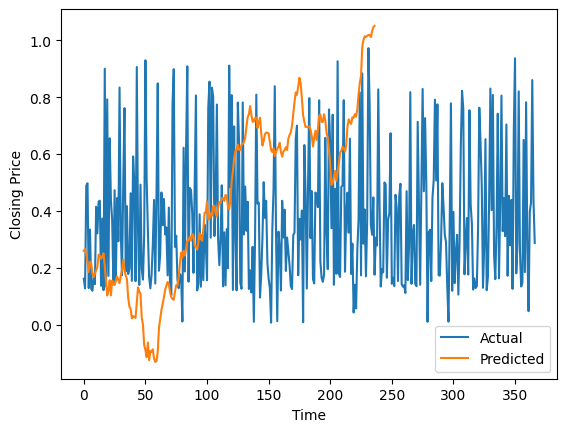

In [22]:
# visualise the predicted new data on the model with the actual data

plt.plot(y_test, label="Actual")
plt.plot(new_predictions, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


In [23]:
#  how much acurate is my model in terms of percentage

mae = loss[1]
accuracy = 100 - (mae / y_test.mean() * 100)
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 97.07%
